# 深度学习进行词性标注（BGRU）

## 1. 导入数据集

In [1]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import gensim

# 训练集和测试集的地址
train_data = '../week7&8_NLP & POS tagging/data/ctb5.1-pos/train.tsv'
test_data = '../week7&8_NLP & POS tagging/data/ctb5.1-pos/test.tsv'

## 2. 数据读取函数

In [2]:
# 读取数据集，并提取出其中的文本部分和标签部分
def get_data(file_path):
    data = pd.read_csv(file_path, sep='\t', 
                       skip_blank_lines=False, 
                       header=None,
                      )
    
    # 取出文本部分
    content = data[0]
    
    # 取出标签部分
    label = data[1]
    
    return content, label

In [3]:
# 使用get_data函数获取训练集和测试集的文本和标签
X_train, y_train = get_data(train_data)
X_test, y_test = get_data(test_data)

## 3. 数据预处理与格式转化

In [4]:
## 构建标签字典
# 合并训练集和测试集的标签
labels = y_train.tolist() + y_test.tolist()
# 利用集合进行去重，再转化为列表格式，获得标签类型列表
labels_types = list(set(labels))
print("训练集和测试集的总标签类别数len(labels_types)为：" + str(len(labels_types)))
print("标签类型列表为：\n", labels_types)

# 构建标签频次字典（标签：该标签出现次数）
labels_dict = {}

# 构建标签索引字典（标签： 该标签的索引）
# 加入{"padded_label" : 0}降低损失率
labels_index = {"padded_label" : 0}

for index in range(len(labels_types)):
    # 根据标签类别列表通过索引获取标签
    label = labels_types[index]
    # 更新标签频次字典
    labels_dict.update({label: labels.count(label)}) 
    # 更新标签索引字典
    labels_index.update({label: index+1}) 
    
print("\n训练集和测试集的总标签数len(labels)为：" + str(len(labels)))

# 输出构建好的标签频次字典
print("\n标签字典的对象数len(labels_dict)为：" + str(len(labels_dict)))
print("标签频次字典内容labels_dict为：\n", labels_dict)

# 输出构建好的标签索引字典
print("\n标签索引字典内容labels_index为：\n", labels_index)

训练集和测试集的总标签类别数len(labels_types)为：36
标签类型列表为：
 [nan, 'AS', 'M', 'P', 'BA', 'NT', 'PU', 'CS', 'AD', 'OD', 'VP', 'DER', 'NN', 'NP', 'CD', 'PN', 'MSP', 'CC', 'DT', 'SP', 'FW', 'IJ', 'ETC', 'LB', 'SB', 'DEV', 'DEC', 'NR', 'LC', 'VE', 'DEG', 'VC', 'JJ', 'VV', 'X', 'VA']

训练集和测试集的总标签数len(labels)为：520125

标签字典的对象数len(labels_dict)为：36
标签频次字典内容labels_dict为：
 {nan: 18426, 'AS': 4118, 'M': 13790, 'P': 17606, 'BA': 755, 'NT': 9659, 'PU': 76753, 'CS': 892, 'AD': 36430, 'OD': 1675, 'VP': 1, 'DER': 258, 'NN': 136643, 'NP': 5, 'CD': 16182, 'PN': 6644, 'MSP': 1336, 'CC': 7355, 'DT': 5986, 'SP': 468, 'FW': 33, 'IJ': 12, 'ETC': 1303, 'LB': 245, 'SB': 455, 'DEV': 634, 'DEC': 12510, 'NR': 30570, 'LC': 7782, 'VE': 3005, 'DEG': 12337, 'VC': 5404, 'JJ': 13234, 'VV': 69858, 'X': 6, 'VA': 7755}

标签索引字典内容labels_index为：
 {'padded_label': 0, nan: 1, 'AS': 2, 'M': 3, 'P': 4, 'BA': 5, 'NT': 6, 'PU': 7, 'CS': 8, 'AD': 9, 'OD': 10, 'VP': 11, 'DER': 12, 'NN': 13, 'NP': 14, 'CD': 15, 'PN': 16, 'MSP': 17, 'CC': 18, 'DT': 

In [5]:
# 保存labels_index字典
np.save('labels_index.npy', labels_index)

In [6]:
# 按句子对X、y进行拆分
def split_corpus_by_sentence(content):
    cleaned_sentence = []
    split_label = content.isnull() # 用来判断是否有缺失值，返回布尔值
    last_split_index = 0
    index = 0
    
    while index < len(content):
        current_word = content[index]
        # 如果有缺失值且cleaned_sentence列表中无内容
        if split_label[index] == True and len(cleaned_sentence) == 0:
            # 添加content列表中从索引last_split_index到index的内容到cleaned_sentence
            cleaned_sentence.append(np.array(content[last_split_index: index]))
            last_split_index = index + 1
            index += 1
            
        # 如果有缺失值且cleaned_sentence列表中有内容
        elif split_label[index] == True and len(cleaned_sentence) > 0:
            cleaned_sentence.append(np.array(content[last_split_index: index]))
            last_split_index = index + 1
            index += 1
            
        else:
            index += 1
    return cleaned_sentence

# 利用上述函数按句子拆分训练集和测试集的文本和标签
X_train_sent_split = split_corpus_by_sentence(X_train)
y_train_sent_split = split_corpus_by_sentence(y_train)
X_test_sent_split = split_corpus_by_sentence(X_test)
y_test_sent_split = split_corpus_by_sentence(y_test)

print('训练集中按句进行拆分后的句子为：\n', X_train_sent_split[:5])
print('\n训练集中按句进行拆分后的句子所对应的词性为：\n', y_train_sent_split[:5])

训练集中按句进行拆分后的句子为：
 [array(['上海', '浦东', '开发', '与', '法制', '建设', '同步'], dtype=object), array(['新华社', '上海', '二月', '十日', '电', '（', '记者', '谢金虎', '、', '张持坚', '）'],
      dtype=object), array(['上海', '浦东', '近年', '来', '颁布', '实行', '了', '涉及', '经济', '、', '贸易', '、',
       '建设', '、', '规划', '、', '科技', '、', '文教', '等', '领域', '的', '七十一', '件',
       '法规性', '文件', '，', '确保', '了', '浦东', '开发', '的', '有序', '进行', '。'],
      dtype=object), array(['浦东', '开发', '开放', '是', '一', '项', '振兴', '上海', '，', '建设', '现代化',
       '经济', '、', '贸易', '、', '金融', '中心', '的', '跨世纪', '工程', '，', '因此',
       '大量', '出现', '的', '是', '以前', '不', '曾', '遇到', '过', '的', '新', '情况',
       '、', '新', '问题', '。'], dtype=object), array(['对', '此', '，', '浦东', '不', '是', '简单', '的', '采取', '“', '干', '一', '段',
       '时间', '，', '等', '积累', '了', '经验', '以后', '再', '制定', '法规', '条例', '”',
       '的', '做法', '，', '而', '是', '借鉴', '发达', '国家', '和', '深圳', '等', '特区',
       '的', '经验', '教训', '，', '聘请', '国内外', '有关', '专家', '学者', '，', '积极',
       '、', '及时', '地', '制定', '和',

In [7]:
# 根据之前构建的标签字典将标签文本转换为索引
def transfer_label_category_index(origin_labels, labels_types):
    transfered_label = []
    for sentence_labels in origin_labels:
        # 将标签依据字典转换为序号
        labels_format_index = [labels_types.index(label) for label in sentence_labels]
        transfered_label.append(labels_format_index)
    return transfered_label

# 利用上述函数将训练集和测试集的标签转换为索引
y_train_index = transfer_label_category_index(y_train_sent_split, labels_types)
y_test_index = transfer_label_category_index(y_test_sent_split, labels_types)

print('训练集中的标签转换为索引对应为：\n', y_train_index[:5])
print('\n测试集中的标签转换为索引对应为：\n', y_test_index[:5])

训练集中的标签转换为索引对应为：
 [[27, 27, 12, 17, 12, 12, 33], [12, 27, 5, 5, 12, 6, 12, 27, 6, 27, 6], [27, 27, 5, 28, 33, 33, 1, 33, 12, 6, 12, 6, 12, 6, 12, 6, 12, 6, 12, 22, 12, 26, 14, 2, 12, 12, 6, 33, 1, 27, 12, 30, 32, 12, 6], [27, 12, 12, 31, 14, 2, 33, 27, 6, 33, 12, 12, 6, 12, 6, 12, 12, 26, 32, 12, 6, 8, 8, 33, 26, 31, 5, 8, 8, 33, 1, 26, 32, 12, 6, 32, 12, 6], [3, 15, 6, 27, 8, 31, 35, 25, 33, 6, 33, 14, 2, 12, 6, 3, 33, 1, 12, 28, 8, 33, 12, 12, 6, 26, 12, 6, 17, 31, 33, 32, 12, 17, 27, 22, 12, 30, 12, 12, 6, 33, 12, 32, 12, 12, 6, 8, 6, 8, 25, 33, 17, 33, 12, 12, 6, 33, 18, 12, 12, 8, 33, 8, 24, 33, 12, 12, 6]]

测试集中的标签转换为索引对应为：
 [[27, 27, 3, 27, 33, 32, 12, 12, 12], [27, 27, 5, 5, 12, 6, 12, 27, 6, 27, 6], [6, 27, 27, 12, 32, 12, 12, 12, 12, 6, 5, 3, 27, 33, 6], [5, 3, 15, 33, 26, 31, 12, 12, 12, 12, 12, 17, 12, 12, 12, 14, 2, 12, 6, 8, 8, 33, 1, 12, 12, 12, 12, 12, 6], [18, 14, 2, 12, 31, 8, 3, 12, 12, 12, 12, 12, 12, 12, 12, 27, 12, 17, 27, 27, 32, 12, 12, 6, 3, 27, 12, 12, 12, 12,

In [8]:
# 设置句子的最大长度为100
MAX_SEQUENCE_LENGTH = 100

## 进行标签格式转化
# 利用zeros(shape, dtype=float, order='C')构建张量，值全为0
# 形状shape对应（标签样本数，句子长度，标签类别数）
y_train_index_padded = np.zeros((len(y_train_index), MAX_SEQUENCE_LENGTH, len(labels_types)+1), # 形状 
                                dtype='float', # 数据类型 
                                order='C',     # c代表与c语言类似，行优先
                               )
y_test_index_padded = np.zeros((len(y_test_index), MAX_SEQUENCE_LENGTH, len(labels_types)+1), # 形状 
                              dtype='float', # 数据类型 
                              order='C',     # c代表与c语言类似，行优先
                              )

''' 
填充张量
嵌套循环遍历：先句子后词
'''
# 训练集
for sentence_labels_index in range(len(y_train_index)):
    for label_index in range(len(y_train_index[sentence_labels_index])):
        if label_index < MAX_SEQUENCE_LENGTH:
            y_train_index_padded[sentence_labels_index, label_index, y_train_index[sentence_labels_index][label_index]+1] = 1
    # 优化：若为填充的标签，则将其预测为第一位为1        
    if len(y_train_index[sentence_labels_index]) < MAX_SEQUENCE_LENGTH:
        for label_index in range(len(y_train_index[sentence_labels_index]), MAX_SEQUENCE_LENGTH):
            y_train_index_padded[sentence_labels_index, label_index, 0] = 1

# 测试集      
for sentence_labels_index in range(len(y_test_index)):
    for label_index in range(len(y_test_index[sentence_labels_index])):
        if label_index < MAX_SEQUENCE_LENGTH:
            y_test_index_padded[sentence_labels_index, label_index, y_test_index[sentence_labels_index][label_index]+1] = 1        
    # 优化：若为填充的标签，则将其预测为第一位为1 
    if len(y_test_index[sentence_labels_index]) < MAX_SEQUENCE_LENGTH:
        for label_index in range(len(y_test_index[sentence_labels_index]), MAX_SEQUENCE_LENGTH):
            y_test_index_padded[sentence_labels_index, label_index, 0] = 1
    
print('训练集中填充的张量为：\n', y_train_index_padded[:1])
print('\n测试集中填充的张量为：\n', y_test_index_padded[:1])

训练集中填充的张量为：
 [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]

测试集中填充的张量为：
 [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]


## 4. word2vec模型导入
预训练的word2vec模型采用前人用中文维基百科训练好的模型

In [9]:
'''（1）导入 预训练的词向量'''

# 本地词向量的地址
myPath = '../week7&8_NLP & POS tagging/data/sgns.wiki.word'   

# 以二进制读取词向量
Word2VecModel = gensim.models.KeyedVectors.load_word2vec_format(myPath).wv

# 词语的向量，是numpy格式
vector = Word2VecModel.wv['空间']
# print(vector)

D:\Anaconda3-5.3.0\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  import sys
D:\Anaconda3-5.3.0\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # Remove the CWD from sys.path while we load stuff.


In [10]:
# 输出词向量的类型
print('词向量的类型为：', type(Word2VecModel.wv))  
# 结果为：Word2VecKeyedVectors

# 获取word2vec训练后model中的所有的词
for i, j in Word2VecModel.wv.vocab.items():
    # 此时 i 代表每个单词
    print(i) 
    
    # j 代表封装了 词频 等信息的 gensim“Vocab”对象
    # 例子：Vocab(count:1481, index:38, sample_int:3701260191)
    print(j)
    
    break

词向量的类型为： <class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
，
Vocab(count:352217, index:0)


D:\Anaconda3-5.3.0\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
D:\Anaconda3-5.3.0\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [11]:
'''（2）构造包含所有词语的list；
        初始化“词语-序号”字典和“词向量”矩阵
'''
# 存储所有的单词和gensim“Vocab”对象
vocab_list = [word for word, Vocab in Word2VecModel.wv.vocab.items()]

# 初始化 `[word : token]` ，后期 tokenize 语料库就是用该词典。
word_index = {" ": 0}

# 初始化`[word : vector]`字典
word_vector = {}

# 初始化 存储所有向量的大矩阵【其中多一位（首行）：词向量全为 0，用于 padding补零。
# 行数为：所有单词数+1。比如 10000+1 ； 
# 列数为：词向量“维度”。比如100。
embeddings_matrix = np.zeros((len(vocab_list)+1, Word2VecModel.vector_size))

D:\Anaconda3-5.3.0\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [12]:
'''（3）填充上述的字典word_index和大矩阵embeddings_matrix'''

# 循环遍历 存储所有的单词和gensim“Vocab”对象的 vocab_list列表
for i in range(len(vocab_list)):
    #print(i)    
    # 将每个词语存储到vocab_list列表中
    word = vocab_list[i]    
    # 将每个词语及对应的序号存储到word_index字典中
    word_index[word] = i + 1   
    # 将每个{词语：词向量}存储到word_vector字典中
    word_vector[word] = Word2VecModel.wv[word]   
    # 将每个{词向量：序号+1}存储到词向量矩阵embeddings_matrix中
    embeddings_matrix[i + 1] = Word2VecModel.wv[word]
    
# 保存word_index字典
np.save('word_index.npy', word_index)

D:\Anaconda3-5.3.0\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda3-5.3.0\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]


In [13]:
'''（4）序号化 文本；
        tokenizer句子；
        并返回每个句子所对应的词语索引
'''
from keras.preprocessing import sequence

# 由于将词语转化为索引的word_index需要与词向量模型对齐，故在导入词向量模型后再将X进行处理
def tokenizer(texts, word_index):
    data = []
    
    for sentence in texts:
        new_sentence = []
        for word in sentence:
            try:
                # 根据word_index字典把文本中的词语转化为index
                new_sentence.append(word_index[word])
            except:
                new_sentence.append(0)
        data.append(new_sentence)
        
    # 使用kears的内置函数padding对齐句子（好处是输出numpy数组，不用自己转化了）
    data = sequence.pad_sequences(data,
                                 maxlen = MAX_SEQUENCE_LENGTH, # 序列的最大长度（大于此长度的序列将被截短，小于此长度的序列将在后部填0）
                                 padding = 'post', # 当需要补0时，在序列的结尾补
                                 truncating = 'post', # 当需要截断序列时，从结尾截断
                                 )
    return data

# 将训练集中的词语转换为索引
X_train_tokenized = tokenizer(X_train_sent_split, word_index)

# 将测试集中的词语转换为索引
X_test_tokenized = tokenizer(X_test_sent_split, word_index)

print('训练集中的词语转换为索引为：\n', X_train_tokenized[:1])
print('\n测试集中的词语转换为索引为：\n', X_test_tokenized[:1])

训练集中的词语转换为索引为：
 [[  347 16980   507    10 15537   603  4380     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]]

测试集中的词语转换为索引为：
 [[  28  523    6 5705 2208  287 1216  587 1523    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0   

## 5. 标引网络构建及训练评估

In [14]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Bidirectional, GRU
import keras
from keras import optimizers

# 词向量维度为300
EMBEDDING_DIM = 300

### Bidirectional GRU

In [15]:
# BGRU模型
def BGRU(embeddings_matrix, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, labels_types):
    model = Sequential()
    model.add(Embedding(input_dim = len(embeddings_matrix), # 字典长度
                        output_dim = EMBEDDING_DIM, # 词向量长度（300）
                        weights = [embeddings_matrix], # 预训练的词向量系数
                        input_length = MAX_SEQUENCE_LENGTH, # 每句话的最大长度（必须padding） 
                        trainable = False, # 是否在训练的过程中更新词向量
                       ),
             )

    ## input_shape=(Batch_size, Time_step, Input_Sizes)
    # 输入层（添加bidirctional）
    model.add(Bidirectional(GRU(128,
                                input_shape=(MAX_SEQUENCE_LENGTH, EMBEDDING_DIM),
                                activation='tanh',
                                return_sequences=True), 
                            merge_mode='concat',
                           ),
             )
    model.add(Dropout(0.5)) # 减少过拟合

    # 隐藏层
    model.add(Dense(64, 
                    input_shape=(MAX_SEQUENCE_LENGTH, 128), # 128维
                    activation='relu',
                   )
             )
    model.add(Dropout(0.5))

    # 输出层
    model.add(Dense(len(labels_types)+1,
                    input_shape=(MAX_SEQUENCE_LENGTH, 64),  # 64维
                    activation='softmax',
                   )
             )
    return model

model = BGRU(embeddings_matrix, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, labels_types)

#### 采用RMSprop优化器

In [16]:
rms = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', # 损失函数
              optimizer=rms, # 优化器采用'rmsprop'
              metrics=['accuracy'], # 评价指标是准确率
             )

In [17]:
# 输出模型各层的参数状况
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          105665400 
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 256)          330240    
_________________________________________________________________
dropout (Dropout)            (None, 100, 256)          0         
_________________________________________________________________
dense (Dense)                (None, 100, 64)           16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 100, 37)           2405      
Total params: 106,014,493
Trainable params: 349,093
Non-trainable params: 105,665,400
____________________________________

#### 对训练集进行再拆分，拆分出验证集

In [18]:
from sklearn.model_selection import train_test_split

# 对训练集进行再拆分，拆分出验证集
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_tokenized, y_train_index_padded)

In [19]:
# 输出训练集中将词语转换为索引后的shape
print('训练集中将词语转换为索引后:', X_train_final.shape)
# 18078个样本,每个样本100个词

# 输出训练集中将标签转换为索引并填充张量后的shape
print('\n训练集中将标签转换为索引并填充张量后', y_train_final.shape)

训练集中将词语转换为索引后: (13558, 100)

训练集中将标签转换为索引并填充张量后 (13558, 100, 37)


In [20]:
# 使用训练集对模型进行训练
network_history = model.fit(X_train_final,
                            y_train_final,
                            epochs = 20,  # 训练20轮
                            batch_size = 128, # 指定进行梯度下降时每个batch包含的样本数为128
                            verbose = 1, # 展示训练过程
                            validation_data = (X_val, y_val) # 验证集数据
                           )

# 用测试集评估训练完成的模型，返回损失值&模型的度量值.
print()
print('* ' * 30 + 'Test Evaluation ' + '* ' * 30)
score = model.evaluate(X_test_tokenized, 
                       y_test_index_padded,
                       batch_size=128,
                      )

Epoch 1/20
106/106 [==============================] - 78s 737ms/step - loss: 0.5892 - accuracy: 0.8760 - val_loss: 0.1763 - val_accuracy: 0.9457
Epoch 2/20
106/106 [==============================] - 80s 758ms/step - loss: 0.1919 - accuracy: 0.9421 - val_loss: 0.1169 - val_accuracy: 0.9620
Epoch 3/20
106/106 [==============================] - 75s 709ms/step - loss: 0.1464 - accuracy: 0.9539 - val_loss: 0.0981 - val_accuracy: 0.9677
Epoch 4/20
106/106 [==============================] - 76s 719ms/step - loss: 0.1280 - accuracy: 0.9595 - val_loss: 0.0893 - val_accuracy: 0.9703
Epoch 5/20
106/106 [==============================] - 78s 738ms/step - loss: 0.1173 - accuracy: 0.9629 - val_loss: 0.0831 - val_accuracy: 0.9721
Epoch 6/20
106/106 [==============================] - 78s 733ms/step - loss: 0.1098 - accuracy: 0.9651 - val_loss: 0.0789 - val_accuracy: 0.9734
Epoch 7/20
106/106 [==============================] - 78s 734ms/step - loss: 0.1041 - accuracy: 0.9668 - val_loss: 0.0763 - val_ac

## 可视化训练信息

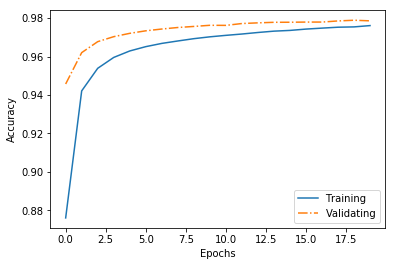

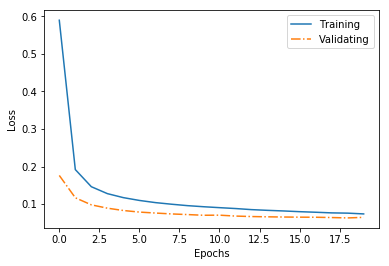

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

# 绘制可视化图形的函数
def plot_history(network_history):
    # 获取数据
    loss = network_history.history['loss']
    accuracy = network_history.history['accuracy']
    val_loss = network_history.history['val_loss']
    val_accuracy = network_history.history['val_accuracy']
    
    ''' 图1：准确率'''    
    plt.figure()
    # 横坐标为次数，纵坐标为训练集的准确率
    plt.plot(accuracy)
    # 横坐标为次数，纵坐标为验证集的准确率
    plt.plot(val_accuracy, linestyle='-.')
    # 设置x，y轴标签
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    # 设置线的标签，位置在图的右下方
    plt.legend(['Training', 'Validating'], loc = 'lower right') 
   
    ''' 图2：损失率'''
    plt.figure()
    # 横坐标为次数，纵坐标为训练集的损失
    plt.plot(loss)
    # 横坐标为次数，纵坐标为验证集的损失
    plt.plot(val_loss, linestyle='-.')
    # 设置x，y轴标签
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # 设置线的标签，位置默认在图的右上方    
    plt.legend(['Training', 'Validating']) 

    plt.show()
    
# 调用上面的函数，并传入参数network_history
plot_history(network_history)

In [23]:
# 保存BiGRU模型
model.save('cn_pos_tag_BiGRU.h5')

### 测试集评估结果

In [24]:
print('训练的模型经在测试集上验证获得的loss和accuracy为：')
print(score)

训练的模型经在测试集上验证获得的loss和accuracy为：
[0.04305679351091385, 0.9861207008361816]


In [25]:
# 对测试集进行预测
print('-----------------------对测试集进行预测------------------------')
print('（1）对测试集 X_test_tokenized[:1] 进行预测：')
print(model.predict(X_test_tokenized[:1]))

-----------------------对测试集进行预测------------------------
（1）对测试集 X_test_tokenized[:1] 进行预测：
[[[3.73076656e-12 6.42712851e-17 1.73028960e-14 ... 1.83664844e-04
   1.09056360e-15 3.97369377e-07]
  [3.78712029e-18 1.57504442e-24 1.24228238e-20 ... 1.55060138e-06
   2.29426626e-23 6.20958340e-10]
  [6.38529790e-18 7.79663115e-22 7.39971913e-14 ... 1.53646793e-03
   2.17048840e-21 3.59033719e-10]
  ...
  [1.00000000e+00 0.00000000e+00 4.11636052e-32 ... 8.45300087e-15
   0.00000000e+00 1.05886874e-23]
  [1.00000000e+00 0.00000000e+00 2.96944355e-31 ... 2.33263997e-14
   0.00000000e+00 5.88495852e-23]
  [1.00000000e+00 0.00000000e+00 2.26503185e-30 ... 6.44060068e-14
   0.00000000e+00 3.52953408e-22]]]


In [26]:
# 输出测试集中标签填充的张量
print('测试集中标签填充的张量 y_test_index_padded[:5] 为：')
print(y_test_index_padded[:5])

测试集中标签填充的张量 y_test_index_padded[:5] 为：
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]


In [27]:
# 对测试集进行预测
print('（2）对测试集 X_test_tokenized[2: 3] 进行预测：')
print(model.predict(X_test_tokenized[2: 3]))

（2）对测试集 X_test_tokenized[2: 3] 进行预测：
[[[1.2163329e-13 5.8711210e-25 1.9815924e-20 ... 8.7441997e-08
   1.2300067e-24 7.8841005e-12]
  [9.9759454e-14 1.4080784e-18 3.3342158e-17 ... 6.8827016e-05
   1.9719188e-17 2.6718936e-08]
  [2.7679751e-20 5.2090778e-26 6.0196579e-24 ... 1.6004677e-07
   2.0896839e-24 5.3573500e-11]
  ...
  [1.0000000e+00 0.0000000e+00 4.2426556e-32 ... 8.5412304e-15
   0.0000000e+00 1.0778107e-23]
  [1.0000000e+00 0.0000000e+00 3.0602698e-31 ... 2.3568344e-14
   0.0000000e+00 5.9902336e-23]
  [1.0000000e+00 0.0000000e+00 2.3340095e-30 ... 6.5069071e-14
   0.0000000e+00 3.5926185e-22]]]


In [28]:
# 输出测试集中标签填充的张量
print('测试集中标签填充的张量 y_test_index_padded[:3] 为：')
print(y_test_index_padded[:3])

测试集中标签填充的张量 y_test_index_padded[:3] 为：
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]
